In [1]:
from pathlib import Path
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd

import sys
sys.path.insert(0, '..')

from scripts.raster_processing.read import read
from scripts.raster_processing.clip import clip
from scripts.data_analysis.predict_population import (
    solve_intercepts_and_slopes,
    get_adjusted_prediction,
    _get_predicted_array,
)
from scripts.data_analysis.get_prefec_projection import get_prefec_projection

# Example notebook

This notebook showcases the workflow of creating 1 prediction raster (so 1 combination of `AGE_GROUP`, `SEX`, and `PREDICT_YEAR`, in one `PREFECTURE`). The complete analysis for producing all of the predictions is scripted, and found in `scripts/predict_all.py`

In [2]:
PREFECTURE = "doufelgou"
AGE_GROUP = 10
SEX = "f"
PREDICT_YEAR = 2030

In [3]:
OBSERVATION_YEARS = [2000, 2005, 2010, 2015, 2020]  # These are the years we have data from

## Reading in data
Here we read in the necessary datasets. The borders and projections are static, but the rasters are of course read based on what we are analysing.

In [4]:
togo_borders = gpd.read_file("../data/input/borders/togo/salb_borders.zip")

In [5]:
pop_projections = pd.read_excel(
    "../data/input/population_projections/Project_Prefect_INSEED.xlsx",
    sheet_name=None,
    skiprows=141,       # We dont want lomé-specific data
    usecols=[0, 1, 2]   # We just need the age, m, f columns
)

In [6]:
region = togo_borders.loc[togo_borders["adm2nm"].str.lower() == PREFECTURE]
region

,db_c4f0x_h,iso3cd,cty_nm,adm1nm,adm2nm,adm1cd,adm2cd,globalid,st_area_sh,st_length_,geometry
9,10,TGO,Togo,Kara,Doufelgou,TGO002,TGO002005,{70AC5005-04F8-4B99-B141-BD5BE4D6DFBA},0.100651,1.797534,"POLYGON ((1.22494 10.04163, 1.22676 10.04064, ..."


In [7]:
raster_names = [f"{SEX}_{AGE_GROUP}_{year}.tif" for year in OBSERVATION_YEARS]
if AGE_GROUP == 0:
    raster_names = zip(raster_names, [f"{SEX}_1_{year}.tif" for year in OBSERVATION_YEARS])

print(raster_names)

['f_10_2000.tif', 'f_10_2005.tif', 'f_10_2010.tif', 'f_10_2015.tif', 'f_10_2020.tif']


In [8]:
raster_directory = Path("../data/output/population_grids_togo/")

images = []
if AGE_GROUP == 0:
    # Sum age groups 0 and 1, since pop projections have only one 0-5 age group
    for names in raster_names:
        to_sum = []
        for name in names:
            print(name)
            with rasterio.open(Path(raster_directory / name)) as raster:
                image, meta = clip(raster, region.geometry)
                to_sum.append(image[0])
        summed = to_sum[0] + to_sum[1]
        images.append(summed)
else:
    for name in raster_names:
        with rasterio.open(Path(raster_directory / name)) as raster:
            image, meta = clip(raster, region.geometry)
            images.append(image[0])

## Preparing the raster data
`images` is now a list containing all 5 rasters, one for each year's data. A raster is just a 2-D array, where the 1st dimension is the raster row, and the 2nd the column. A single element in one row-column combination represents a pixel. All spatial information is stored in `meta`.

Here we simply assign the images to an array to make working with them more efficient. We also assign all nodata values.

In [9]:
# use np.nan for nodata
images = np.array(images)
images[images < 0] = np.nan
images

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ..

The images seem to be filled with nodata values. But, of course, this is not the actual case - it is just caused by the fact that the top and bottom rows of rasters depicting non-square areas are often mostly nodata.

Lets plot a single raster to see we actually have some data:

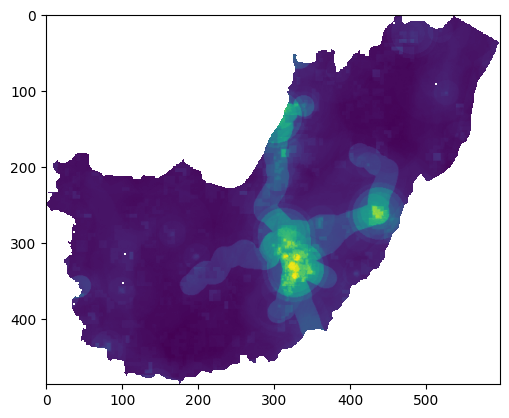

In [10]:
plt.imshow(images[4])  # Plotting the last raster

In [11]:
images[0].shape  # Shape of the 1st raster

(487, 598)

It is worth noting that `images` is now a 3-dimensional array: 5 rasters, each with 487 rows and each row with 598 values.

In [12]:
images.shape

(5, 487, 598)

Also worth noting is the metadata found in `meta`. Since all of the rasters are geographically speaking exactly the same (the only differences between them are the values in their image arrays), we can later on use this same metadata for spatially referencing our output.

In [13]:
meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -99999.0,
 'width': 598,
 'height': 487,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.00083333333, 0.0, 0.8354166782499995,
        0.0, -0.00083333333, 10.042083494829999)}

Now that we have our images in an array, we need to somehow associate the yearly observations as belonging to the same cell. We can accomplish this with `np.dstack` by stacking the `images` array along its 3rd dimension. 

In [14]:
stack = np.dstack(images)

You can think of the stack as a ordinary 2-D array of a single raster, but instead of a single value, each cell is now a list of said cell's values from each stacked array, hence the 3rd dimension.

In [15]:
stack.shape

(487, 598, 5)

Since our analysis is concerned only with linear models on the values of single cells, we can still simplify our data. We do not need the row-column structure of a raster, so we can reshape our array to contain all data in 2 dimensions: each row now holds the values of each cell, as a sort of time series.

In [16]:
time_series = stack.reshape((-1, 5))
time_series

array([[nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       ...,
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan]], dtype=float32)

In [17]:
time_series.shape  # lots of rows, each row has 5 observations

(291226, 5)

## The predictions
So, for the predictions we need the observed population values for each cell, and the years to associate with those values. After assigning the observation years to an array, we have both.

In [18]:
year_arr = np.array(OBSERVATION_YEARS)

With our 2-dimensional time series data and the year array, we can apply a linear model very efficiently. This is done by first solving the intercepts and slopes of the regression lines for each time series (each row) with `solve_intercepts_and_slopes()`. The function returns two arrays - the intercepts and slopes. With these, we can calculate values at any point on the regression line. Here we are simply interested in the value at `x=PREDICT_YEAR`. This is done for every element of the array, so the result is an array with single-value elements instead of time series. These new values are the predictions for our desired value of `x`, or, in other words, time.

In [19]:
intercepts, slopes = solve_intercepts_and_slopes(periods=year_arr, time_series=time_series)
predict_arr = _get_predicted_array(intercepts, slopes, PREDICT_YEAR)
predict_arr.shape

(291226,)

Now we can just shape our prediction array back to 2-D (the row-column format required for rasters).

In [20]:
predict_arr = predict_arr.reshape(images[0].shape)  # all the images have the same shape
predict_arr.shape

(487, 598)

## Adjusting the predictions
To adjust the predictions to the population projections, we need to apply a multiplier to all of the predicted values.

In [21]:
raster_sum = np.nansum(predict_arr)  # total predicted population

# Population projection
pop_projection = get_prefec_projection(
    pop_projections,
    PREFECTURE,
    PREDICT_YEAR,
    AGE_GROUP,
    SEX
)

In [22]:
multiplier = pop_projection / raster_sum
adjusted_arr = np.multiply(predict_arr, multiplier)  # Adjust all values

print(np.nansum(adjusted_arr), pop_projection)

6859.386700305408 6859.386700305408


Now, to check if our data still looks sensible, some plotting is due. Here's (from left to right) the year 2000 population, the population of our prediction year, and their difference.

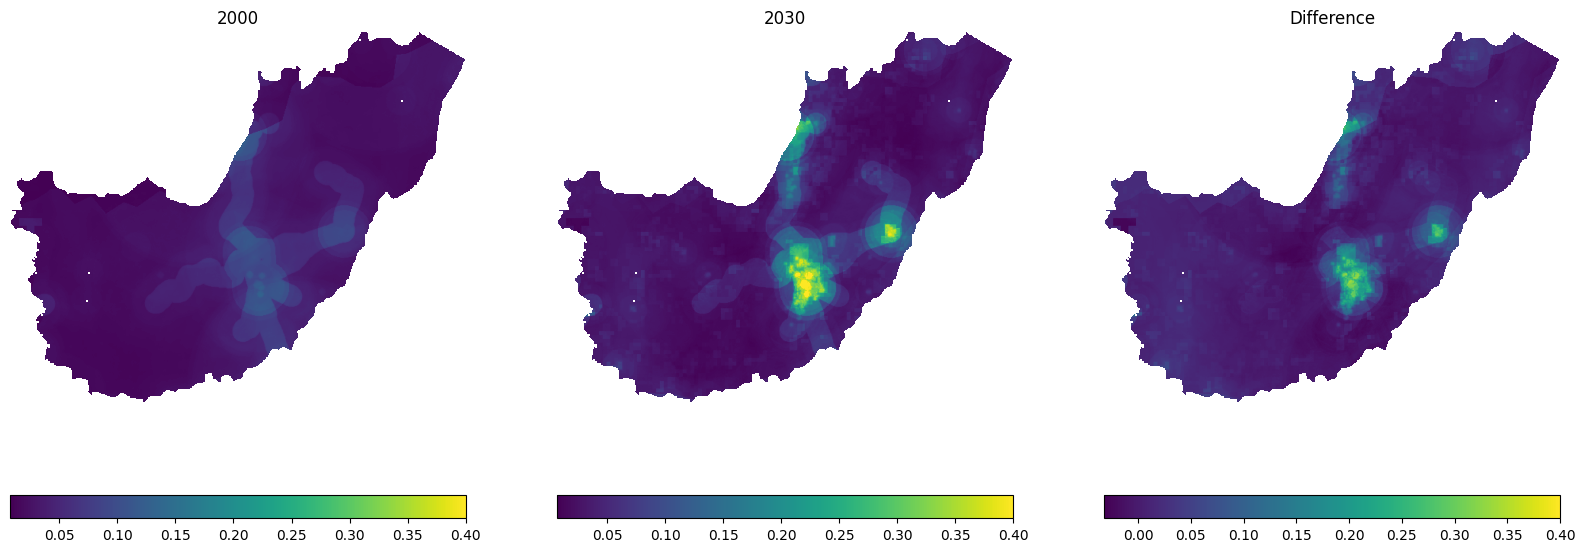

In [23]:
fig, axs = plt.subplots(figsize=(20, 8), ncols=3)

comparison = images[0]

arrs = [comparison, adjusted_arr, adjusted_arr-comparison]
titles = ["2000", f"{PREDICT_YEAR}", "Difference"]

for i, arr in enumerate(arrs):
    axs[i].set_title(titles[i])
    mappable = axs[i].imshow(
        arr,
        vmax=0.4,
    )
    fig.colorbar(mappable, ax=axs[i], location="bottom")
    axs[i].set_axis_off()

And finally, to write out our data:

In [24]:
with rasterio.open(
    f"./{PREFECTURE}_{SEX}_{AGE_GROUP}_{PREDICT_YEAR}.tif",
    "w",
    driver="GTiff",                 # output file type
    height=adjusted_arr.shape[0],   # shape of array
    width=adjusted_arr.shape[1],
    count=1,                        # number of bands
    dtype=adjusted_arr.dtype,       # output datatype
    crs="+proj=latlong",            # CRS
    transform=meta["transform"],    # location and resolution of upper left cell
    nodata=np.nan                   # nans to nodata
) as dst:
    dst.write(adjusted_arr, 1)

## A single-cell example of the linear model

This is just to visually see the linear model we produce makes sense. The approach used has also been validated to produce results identical to the much more computationally heavy linear model from `sklearn`.

In [25]:
intercepts, slopes = solve_intercepts_and_slopes(year_arr, time_series)
row_i = 156294  # just pick a random row

intercept, slope = intercepts[row_i], slopes[row_i]
intercept, slope

(0.893585521728296, -0.00043493021279602634)

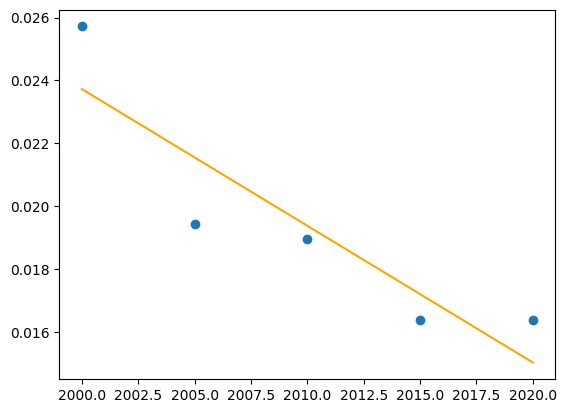

In [26]:
reg_line_values = [_get_predicted_array(intercept, slope, year) for year in year_arr]

plt.scatter(year_arr, time_series[row_i])
plt.plot(year_arr, reg_line_values, color="orange")